## ----- SYSTEMS -----

In [1]:
import os
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as tf

import wandb

from functools import partial

from timm.models.vision_transformer import PatchEmbed, Block

from torch.utils.data import Dataset, DataLoader, ConcatDataset

from tqdm import tqdm

IMAGE_SIZE = 224
BATCH_SIZE = 32

c:\Users\detac\miniconda3\envs\pytorch_2_1_0_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set random seed for reproducibility
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(device))

NVIDIA GeForce RTX 4060 Laptop GPU


## ----- DATASET -----

In [3]:
class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        """
        Args:
            root (str): Path to the dataset directory.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root = root
        self.file_names = sorted(os.listdir(self.root))
        self.image_names = [f for f in self.file_names if f[0] == "a" and f.endswith(".jpg")]
        self.transform = transform

    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image = cv2.imread(os.path.join(self.root, image_name), cv2.IMREAD_GRAYSCALE)
        
        # To tensor and unsqueeze
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) ## [H, W] -> [1, H, W]
        
        if self.transform:
            image = self.transform(image)
        
        # Broadcasting to 3 channels
        image = image.repeat(3, 1, 1)
        
        return image

In [4]:
class Augmentation(nn.Module):
    def __init__(self, color_jitter=True, resized_crop=True, horizontal_flip=True):
        self.color_jitter = color_jitter
        self.resized_crop = resized_crop
        self.horizontal_flip = horizontal_flip
    
    def __call__(self, image):
        """ Normalization """
        image = image / 255.0
        
        """ Random Color Jitter"""
        if self.color_jitter and random.random() < 0.5:
            color_transform = tf.Compose([
                tf.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
            ])
            image = color_transform(image)
        
        """ Random Resized Crop """
        if self.resized_crop and random.random() < 0.5:
            # Get parameters for RandomResizedCrop
            top, left, height, width = tf.RandomResizedCrop.get_params(image, scale=(0.7, 1.0), ratio=(0.8, 1.2))
            
            # Apply RandomResizedCrop
            image = tf.functional.resized_crop(
                image,
                top, left, height, width,
                (IMAGE_SIZE, IMAGE_SIZE),
                interpolation=tf.InterpolationMode.BILINEAR,
                antialias=True
            )
        
        """ Random Horizontal Flip """
        if self.horizontal_flip and random.random() < 0.5:
            image = tf.functional.hflip(image)

        """ Resize """
        image = tf.functional.resize(image, (IMAGE_SIZE, IMAGE_SIZE), interpolation=tf.InterpolationMode.BILINEAR, antialias=True)
        
        # Remove leading dimension
        image = image.squeeze(0) ## [1, H, W] -> [H, W]
        
        return image

In [5]:
# Create pretrain dataset and loader

pretrain_transform = Augmentation()
pretrain_folder_list = [os.path.join("./pretrain_data", folder) for folder in os.listdir("./pretrain_data")]

dataset_list = []
for folder in pretrain_folder_list:
    dataset_list.append(CustomDataset(folder, transform=pretrain_transform))

pretrain_dataset = ConcatDataset(dataset_list)
pretrain_loader = DataLoader(pretrain_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
print(f"Number of training samples: {len(pretrain_dataset)}")

Number of training samples: 11475


Batch 0 - Image shape: torch.Size([32, 3, 224, 224])


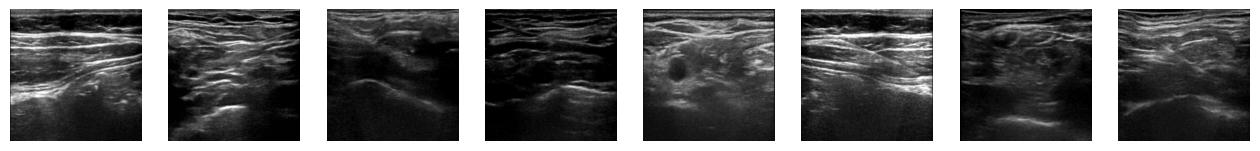

Batch 1 - Image shape: torch.Size([32, 3, 224, 224])


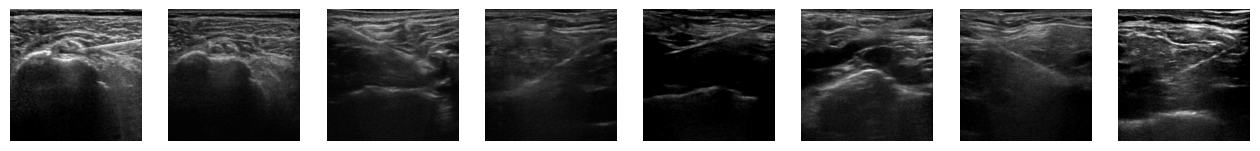

Batch 2 - Image shape: torch.Size([32, 3, 224, 224])


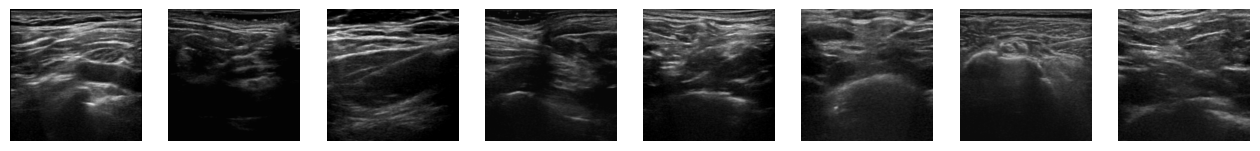

Batch 3 - Image shape: torch.Size([32, 3, 224, 224])


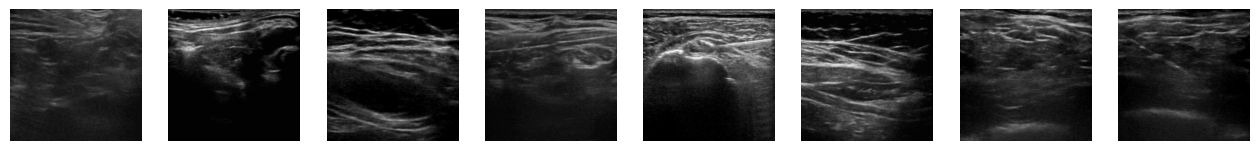

In [6]:
# Visualize 4 batch of images (show only 8 images at most)

def show_images(imgs):
    plt.figure(figsize=(16, 8))
    for i, img in enumerate(imgs):
        img = img.permute(1, 2, 0).numpy()
        img[img <= 0] = 0
        img[img >= 1] = 1
        img = (img * 255).astype(np.uint8)
        plt.subplot(1, 8, i+1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        if i == 7:
            break
    plt.show()

for batch, images in enumerate(pretrain_loader):
    print(f"Batch {batch} - Image shape: {images.shape}")
    show_images(images)
    if batch == 3:
        break

## ----- MODEL -----

In [7]:
# Positional Encoding for ViT

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed

def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb

def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


# MAE ViT model
class MaskedAutoencoderViT(nn.Module):
    """ Masked Autoencoder with VisionTransformer backbone
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        # --------------------------------------------------------------------------

        # --------------------------------------------------------------------------
        # MAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        # embed patches
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove, 
        """
        target = self.patchify(imgs)
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6)**.5

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss

    def forward(self, imgs, mask_ratio=0.75):
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
        loss = self.forward_loss(imgs, pred, mask)
        return loss, pred, mask

## ----- TRAINING FUNCTION -----

In [8]:
# Training Function
def train(experiment_id, model, pretrain_loader, optimizer, device, epochs, accumulation_steps=2, mask_ratio=0.75):
    model.train()
    model.to(device)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        running_loss = 0.0
        
        for step, images in enumerate(tqdm(pretrain_loader)):
            images = images.to(device)
            
            # Forward pass
            loss, preds, masks = model(images, mask_ratio=mask_ratio)
            running_loss += loss.item()
            
            # Gradient accumulation normalization
            loss = loss / accumulation_steps
            loss.backward()
            
            # Update weights
            if (step + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
            
        # Print loss
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(pretrain_loader)}")
        
        # Log to wandb
        wandb.log({"Training MSE Loss": running_loss/len(pretrain_loader)})
        running_loss = 0.0
        
        if (epoch + 1) % 10 == 0:
            # Save the model
            torch.save(model.state_dict(), f"./ultrasound_mae_ckeckpoints_mr_75/mae_vit_base_patch16_ep_{epoch+1}_{experiment_id}.pth")
            
            # visualize reconstructed images for the first 2 batches
            model.eval()
            with torch.no_grad():
                for batch, images in enumerate(pretrain_loader):
                    images = images.to(device)
                    loss, pred, mask = model(images, mask_ratio=mask_ratio)
                    images = images.detach().cpu()
                    pred_imgs = model.unpatchify(pred)
                    pred_imgs = pred_imgs.detach().cpu()
                    print("Original Images")
                    show_images(images)
                    print("Reconstructed Images")
                    show_images(pred_imgs)
                    if batch == 1:
                        break
            model.train()
        
    print("Finished Training!")

## ----- LAYER LEARNING RATE DECAY -----

In [9]:
def get_layer_lr(model, lr, decay_rate=0.98):
    """
    Get the learning rate for each layer in the ViT model
    """
    layer_names = []
    for name, param in model.named_parameters():
        layer_names.append((name))
    layer_names.reverse()
    
    # store params & learning rates
    parameters = []
    
    for name in layer_names:
        # append layer parameters
        parameters += [
            {
                'params': [p for n, p in model.named_parameters() if n == name and p.requires_grad],
                'lr': lr
            }
        ]
        
        # decay learning rate
        lr *= decay_rate
    parameters.reverse()
    
    return parameters

## ----- EXPERIMENTS -----

In [ ]:
# Experiment 1
experiment_id = 1
name = f"MAE-ViT-{experiment_id}"


# Define the mask ratio
mask_ratio = 0.75


# Pre-trained MAE ViT weights
# vit_pretrained_weights = "None"
vit_pretrained_weights = "MAE ImageNet 1k"


# Define the model parameters
patch_size = 16
embed_dim = 768
depth = 12
num_heads = 12
decoder_embed_dim = 512
decoder_depth = 8
decoder_num_heads = 16
mlp_ratio = 4
if vit_pretrained_weights == "MAE ImageNet 1k":
    norm_pix_loss = True
else:
    norm_pix_loss = False


# Create the model
mae_vit = MaskedAutoencoderViT(
    img_size=IMAGE_SIZE,
    patch_size=patch_size,
    embed_dim=embed_dim,
    depth=depth,
    num_heads=num_heads,
    decoder_embed_dim=decoder_embed_dim,
    decoder_depth=decoder_depth,
    decoder_num_heads=decoder_num_heads,
    mlp_ratio=mlp_ratio,
    norm_layer=partial(nn.LayerNorm, eps=1e-6),
    norm_pix_loss=norm_pix_loss
)


# load pre-trained weights
if vit_pretrained_weights == "MAE ImageNet 1k":
    checkpoint = torch.load("./mae_pretrain_vit_base_full.pth")
    mae_vit.load_state_dict(checkpoint['model'])
    print("Pretrained Weights Loaded!")


# number of parameters in the model
num_params = sum(p.numel() for p in mae_vit.parameters())


# training epochs
if vit_pretrained_weights == "MAE ImageNet 1k":
    epochs = 50
else:
    epochs = 100


# learning rate & optimizer
blr = 1.5e-4
accumulation_steps = 2
eff_batch_size = accumulation_steps * BATCH_SIZE
lr = blr * eff_batch_size / 256


# get layer-wise learning rates if using MAE ImageNet 1k pretrained weights
if vit_pretrained_weights == "MAE ImageNet 1k":
    decay_rate = 0.98
    parameters = get_layer_lr(mae_vit, lr, decay_rate=decay_rate)
    optimizer = torch.optim.AdamW(parameters, betas=(0.9, 0.95), weight_decay=0.05)
else:
    decay_rate = "None"
    optimizer = torch.optim.AdamW(mae_vit.parameters(), lr=lr, betas=(0.9, 0.95), weight_decay=0.05)


# Start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="DLMI HW",
    
    # Set the experiment name
    name=name,

    # track hyperparameters and run metadata
    config={
    "Architecture": "MAE-ViT",
    "Mask Ratio": mask_ratio,
    "ViT patch_size": patch_size,
    "ViT Encoder Pre-Trained Weights": vit_pretrained_weights,
    "ViT Encoder embed_dim": embed_dim,
    "ViT Encoder depth": depth,
    "ViT Encoder num_heads": num_heads,
    "ViT Decoder Pre-Trained Weights": vit_pretrained_weights,
    "ViT Decoder embed_dim": decoder_embed_dim,
    "ViT Decoder depth": decoder_depth,
    "ViT Decoder num_heads": decoder_num_heads,
    "ViT mlp_ratio": mlp_ratio,
    "Number of Parameters": num_params,
    "Number of Pre-Trained Images": len(pretrain_dataset),
    "Image Size": IMAGE_SIZE,
    "Device Batch Size": BATCH_SIZE,
    "Effective Batch Size": eff_batch_size,
    "Epochs": epochs,
    "Base Learning Rate": blr,
    "Layer-wise Learning Rate Decay": decay_rate,
    "Optimizer": "AdamW",
    "Loss Functions": "MSE Loss", 
    "Normalized Target Reconstruction Loss": norm_pix_loss,
    }
)


# train the model
train(
    experiment_id=experiment_id,
    model=mae_vit,
    pretrain_loader=pretrain_loader,
    optimizer=optimizer,
    device=device,
    epochs=epochs,
    accumulation_steps=accumulation_steps,
    mask_ratio=mask_ratio,
)


# Finish the wandb logging
wandb.finish() 